In [1]:
from matplotlib.colors import ListedColormap
from matplotlib.cm import ScalarMappable

In [31]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.ndimage import gaussian_filter1d
from scipy.stats import binom
from matplotlib import gridspec

sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 14, 'font.family': 'Verdana'})
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

num_checkpoints = 30
num_batches = 4
batch_size = 256

In [3]:
simclr_stats = torch.load('stats/simclr-200-stats.pt')
simclr_first = {'prob': [], 'argmax': []}
simclr_second = {'prob': [], 'argmax': []}

for i in range(num_batches):
    simclr_first['prob'] += [simclr_stats['prob'][..., 2 * i * batch_size: (2 * i + 1) * batch_size]]
    simclr_second['prob'] += [simclr_stats['prob'][..., (2 * i + 1) * batch_size: 2 * (i + 1) * batch_size]]
    
    simclr_first['argmax'] += [simclr_stats['argmax'][..., 2 * i * batch_size: (2 * i + 1) * batch_size]]
    simclr_second['argmax'] += [simclr_stats['argmax'][..., (2 * i + 1) * batch_size: 2 * (i + 1) * batch_size]]

simclr_first['prob'] = torch.cat(simclr_first['prob'], dim=-1)
simclr_second['prob'] = torch.cat(simclr_second['prob'], dim=-1)
simclr_first['argmax'] = torch.cat(simclr_first['argmax'], dim=-1).to(torch.float)
simclr_second['argmax'] = torch.cat(simclr_second['argmax'], dim=-1).to(torch.float)

In [4]:
supervised_stats = torch.load('stats/supervised-cifar10-50-stats.pt')
randy_stats = torch.load('stats/supervised-randy-20-stats.pt')
randy_aug_stats = torch.load('stats/supervised-randy-aug-500-stats.pt')

supervised_stats['argmax'] = supervised_stats['argmax'].to(torch.float)
randy_stats['argmax'] = randy_stats['argmax'].to(torch.float)
randy_aug_stats['argmax'] = randy_aug_stats['argmax'].to(torch.float)

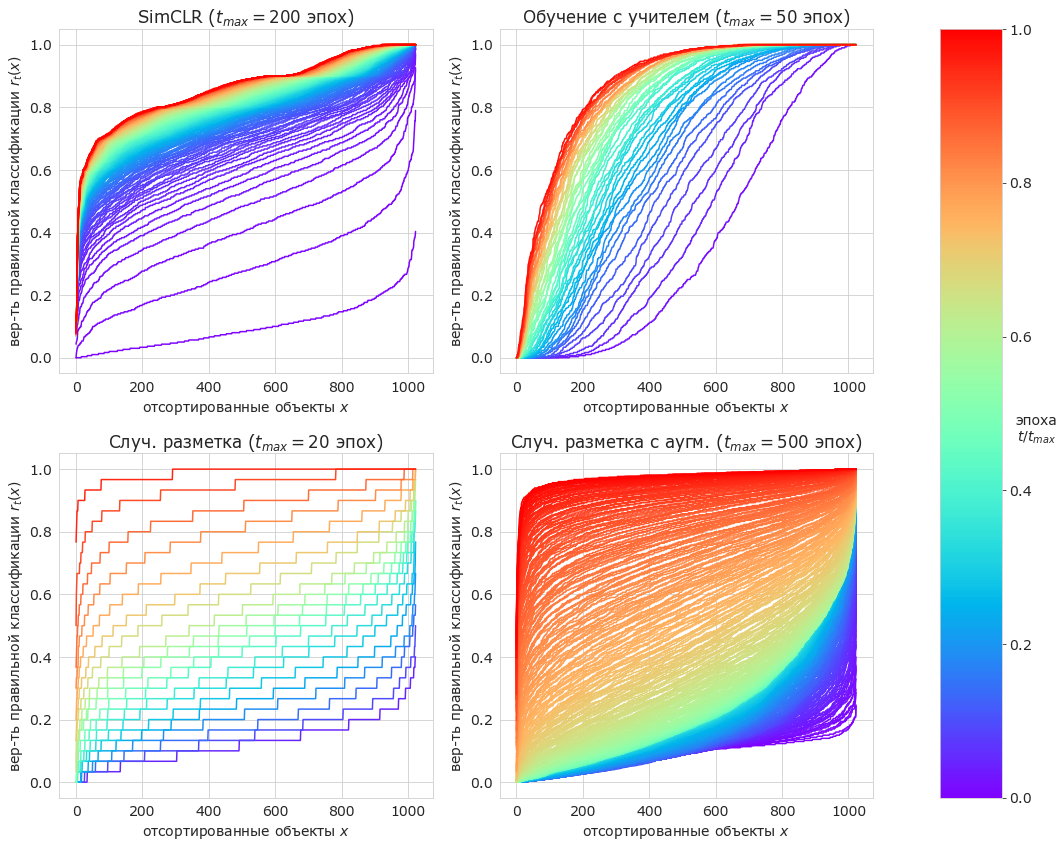

In [36]:
fig, axs = plt.subplots(2, 3, figsize=(15, 12), gridspec_kw={'width_ratios': [6, 6, 1]})

colors = sns.color_palette('rainbow', 200)
for i in range(200):
    shares, _ = torch.sort(simclr_first['argmax'][:, i].mean((0, 1)))
    axs[0, 0].plot(shares, color=colors[i])

colors = sns.color_palette('rainbow', 50)
for i in range(50):
    shares, _ = torch.sort(supervised_stats['argmax'][:, i].mean((0, 1)))
    axs[0, 1].plot(shares, color=colors[i])

colors = sns.color_palette('rainbow', 20)
for i in range(20):
    shares, _ = torch.sort(randy_stats['argmax'][:, i].mean((0, 1)))
    axs[1, 0].plot(shares, color=colors[i])
    
colors = sns.color_palette('rainbow', 500)
for i in range(0, 500):
    shares, _ = torch.sort(randy_aug_stats['argmax'][:, i].mean((0, 1)))
    axs[1, 1].plot(shares, color=colors[i])

fig.subplots_adjust(wspace=0.25, hspace=0.3, right=0.8)
gs = axs[0, 2].get_gridspec()
for ax in axs[:, -1]:
    ax.remove()

axbig = fig.add_subplot(gs[:, -1])
cmap = ListedColormap(colors.as_hex())
cbar = fig.colorbar(ScalarMappable(cmap=cmap), cax=axbig)
cbar.set_label('эпоха\n' + r'$t/t_{max}$', rotation=0)

for ax in axs[:, :2].flatten():
    ax.set_ylabel(r'вер-ть правильной классификации $r_t(x)$')
    ax.set_xlabel(r'отсортированные объекты $x$')

axs[0, 0].set_title(r'SimCLR ($t_{max}=200$ эпох)')
axs[0, 1].set_title(r'Обучение с учителем ($t_{max}=50$ эпох)')
axs[1, 0].set_title(r'Случ. разметка ($t_{max}=20$ эпох)')
axs[1, 1].set_title(r'Случ. разметка с аугм. ($t_{max}=500$ эпох)')
plt.tight_layout()
plt.savefig('plots/training_dynamics.pdf')
plt.show()

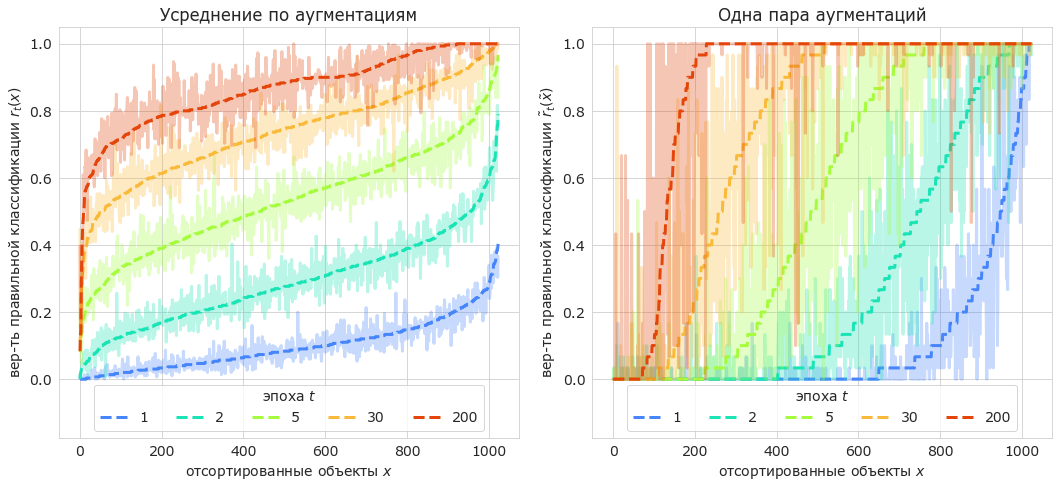

In [59]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7))
colors = sns.color_palette('turbo', 5)

for i, epoch in enumerate([1, 2, 5, 30, 200]):
    indices = torch.argsort(simclr_first['argmax'][:, epoch - 1].mean((0, 1)))
    first_shares = simclr_first['argmax'][:, epoch - 1].mean((0, 1))
    second_shares = simclr_second['argmax'][:, epoch - 1].mean((0, 1))
    axs[0].plot(first_shares[indices], color=colors[i], linestyle='--', label=f'{epoch}', linewidth=3)
    axs[0].plot(second_shares[indices], color=colors[i], alpha=0.3, linewidth=3)
    
    indices = torch.argsort(simclr_first['argmax'][:, epoch - 1, 0].mean(0))
    first_shares = simclr_first['argmax'][:, epoch - 1, 0].mean(0)
    second_shares = simclr_second['argmax'][:, epoch - 1, 0].mean(0)
    axs[1].plot(first_shares[indices], color=colors[i], linestyle='--', label=f'{epoch}', linewidth=3)
    axs[1].plot(second_shares[indices], color=colors[i], alpha=0.3, linewidth=3)

for ax in axs:
    ax.set_xlabel('отсортированные объекты $x$')
    ax.set_ylim(ymin=-0.175)
    ax.legend(title='эпоха $t$', ncol=5, loc='lower center')

axs[0].set_ylabel(r'вер-ть правильной классификации $r_t(x)$')
axs[1].set_ylabel(r'вер-ть правильной классификации $\tilde{r}_t(\tilde{x})$')
axs[0].set_title('Усреднение по аугментациям')
axs[1].set_title('Одна пара аугментаций')

plt.tight_layout()
plt.savefig('plots/first_second.pdf')
plt.show()

In [10]:
simclr_areas = simclr_first['argmax'].mean((0, 2, 3)).numpy()
supervised_areas = supervised_stats['argmax'].mean((0, 2, 3)).numpy()
randy_areas = randy_stats['argmax'].mean((0, 2, 3)).numpy()
randy_aug_areas = randy_aug_stats['argmax'].mean((0, 2, 3)).numpy()

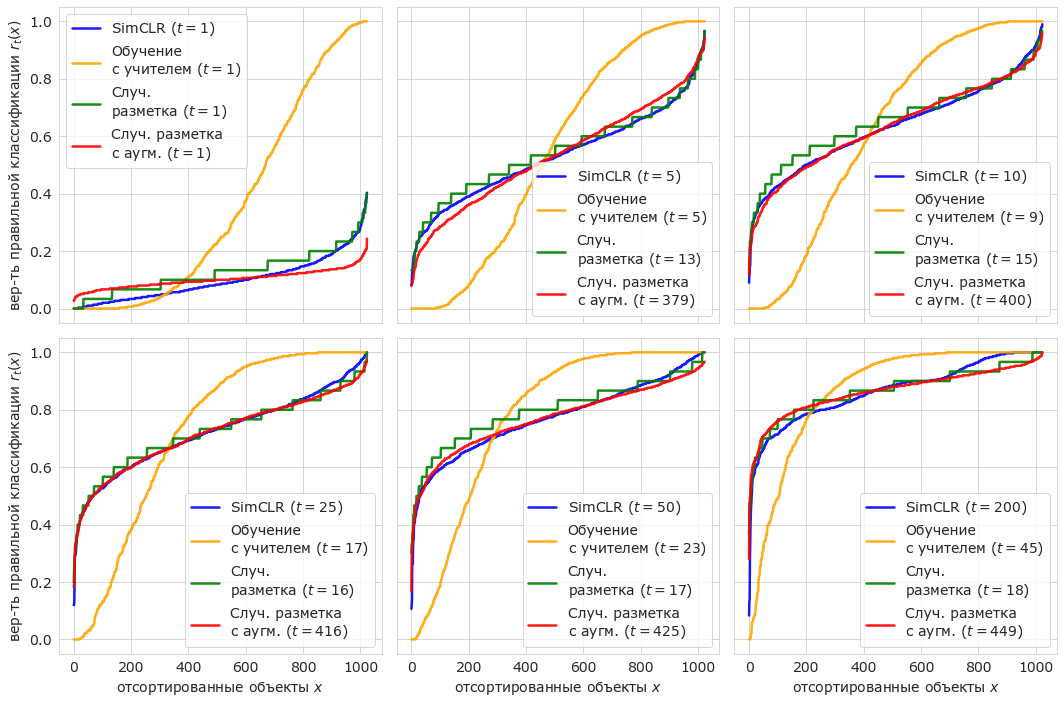

In [11]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
epochs = [1, 5, 10, 25, 50, 200]

for ax, epoch in zip(axs.flatten(), epochs):
    thr = simclr_areas[epoch - 1]
    shares, _ = torch.sort(simclr_first['argmax'][:, epoch - 1].mean((0, 1)))
    ax.plot(shares, label=f'SimCLR ($t={epoch}$)', linewidth=2.5, alpha=0.9, color='blue')
    
    index = np.argmin(np.abs(supervised_areas - thr))
    shares, _ = torch.sort(supervised_stats['argmax'][:, index].mean((0, 1)))
    ax.plot(shares, label=f'Обучение\nс учителем ($t={index + 1}$)', linewidth=2.5, alpha=0.9, color='orange')
    
    index = np.argmin(np.abs(randy_areas - thr))
    shares, _ = torch.sort(randy_stats['argmax'][:, index].mean((0, 1)))
    ax.plot(shares, label=f'Случ.\nразметка ($t={index + 1}$)', linewidth=2.5, alpha=0.9, color='green')
    
    index = np.argmin(np.abs(randy_aug_areas - thr))
    shares, _ = torch.sort(randy_aug_stats['argmax'][:, index].mean((0, 1)))
    ax.plot(shares, label=f'Случ. разметка\nс аугм. ($t={index + 1}$)', linewidth=2.5, alpha=0.9, color='red')
    ax.legend()

for ax in axs[:, 0]:
    ax.set_ylabel(r'вер-ть правильной классификации $r_t(x)$')

for ax in axs[:, 1:].flatten():
    ax.set_yticklabels([])

for ax in axs[1, :]:
    ax.set_xlabel('отсортированные объекты $x$')
    
for ax in axs[0, :]:
    ax.set_xticklabels([])

plt.subplots_adjust(wspace=0.02, hspace=0.02)
plt.tight_layout()
plt.savefig('plots/equal_areas.pdf')
plt.show()

In [12]:
import scipy.stats

def chisquare_binom(sample, n):
    p = sample.mean() / n

    counts = np.bincount(sample)
    freq_obs = np.zeros(n + 1, dtype=int)
    freq_obs[:counts.shape[0]] = counts
    freq_exp = scipy.stats.binom.pmf(np.arange(n + 1), n=n, p=p) * sample.shape[0]

    result = scipy.stats.chisquare(freq_obs, freq_exp, ddof=1)
    return result

def get_sample(tensor, epoch, aug):
    return tensor[:, epoch, aug, :].numpy().astype(int).sum(axis=0)

In [13]:
simclr_areas = simclr_first['argmax'][:, :, 0].mean((0, 2)).numpy()
supervised_areas = supervised_stats['argmax'][:, :, 0].mean((0, 2)).numpy()
randy_areas = randy_stats['argmax'][:, :, 0].mean((0, 2)).numpy()
randy_aug_areas = randy_aug_stats['argmax'][:, :, 0].mean((0, 2)).numpy()

In [14]:
ratios = [0.25, 0.5, 0.75]

for ratio in ratios:
    index = np.nonzero(simclr_areas >= ratio)[0][0]
    sample = get_sample(simclr_first['argmax'], index, 0)
    s, p = chisquare_binom(sample, n=30)
    print(f'SimCLR: t={index + 1}, p={simclr_areas[index]:.3f}, s={s:.1e}, p={p}')
    
print()
for ratio in ratios:
    index = np.nonzero(supervised_areas >= ratio)[0][0]
    sample = get_sample(supervised_stats['argmax'], index, 0)
    s, p = chisquare_binom(sample, n=30)
    print(f'Обуч. с учителем: t={index + 1}, p={supervised_areas[index]:.3f}, s={s:.1e}, p={p}')

print()
for ratio in ratios:
    index = np.nonzero(randy_areas >= ratio)[0][0]
    sample = get_sample(randy_stats['argmax'], index, 0)
    s, p = chisquare_binom(sample, n=30)
    print(f'Случ. разметка: t={index + 1}, p={randy_areas[index]:.3f}, s={s:.1e}, p={p}')

print()
for ratio in ratios:
    index = np.nonzero(randy_aug_areas >= ratio)[0][0]
    sample = get_sample(randy_aug_stats['argmax'], index, 0)
    s, p = chisquare_binom(sample, n=30)
    print(f'Случ. разметка с аугм.: t={index + 1}, p={randy_aug_areas[index]:.3f}, s={s:.1e}, p={p}')

SimCLR: t=2, p=0.279, s=1.3e+17, p=0.0
SimCLR: t=5, p=0.521, s=2.1e+11, p=0.0
SimCLR: t=39, p=0.751, s=1.3e+19, p=0.0

Обуч. с учителем: t=1, p=0.368, s=6.7e+13, p=0.0
Обуч. с учителем: t=4, p=0.512, s=8.0e+10, p=0.0
Обуч. с учителем: t=20, p=0.752, s=2.4e+18, p=0.0

Случ. разметка: t=5, p=0.265, s=8.4e+04, p=0.0
Случ. разметка: t=12, p=0.515, s=4.2e+04, p=0.0
Случ. разметка: t=17, p=0.798, s=4.5e+05, p=0.0

Случ. разметка с аугм.: t=278, p=0.251, s=4.4e+13, p=0.0
Случ. разметка с аугм.: t=374, p=0.501, s=5.2e+06, p=0.0
Случ. разметка с аугм.: t=423, p=0.751, s=5.9e+08, p=0.0


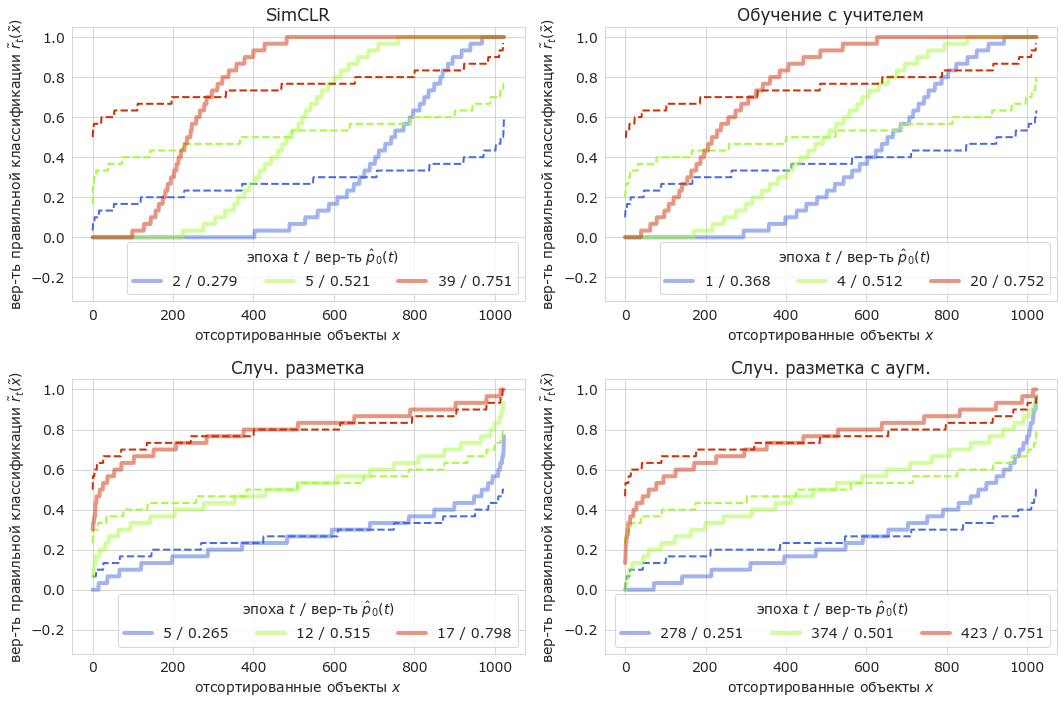

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
ratios = [0.25, 0.5, 0.75]
colors = sns.color_palette('turbo', 7)
colors = [colors[0], colors[3], colors[6]]

for i, ratio in enumerate(ratios):
    index = np.nonzero(simclr_areas >= ratio)[0][0]
    shares, _ = torch.sort(simclr_first['argmax'][:, index, 0].mean((0)))
    axs[0, 0].plot(shares, label=f'{index + 1} / {simclr_areas[index]:.3f}',
                   color=colors[i], linewidth=4, alpha=0.5)
    noise = binom.rvs(p=shares.mean(), n=30, size=1024) / 30
    axs[0, 0].plot(np.sort(noise), color=colors[i], linestyle='--', linewidth=2)
    
for i, ratio in enumerate(ratios):
    index = np.nonzero(supervised_areas >= ratio)[0][0]
    shares, _ = torch.sort(supervised_stats['argmax'][:, index, 0].mean((0)))
    axs[0, 1].plot(shares, label=f'{index + 1} / {supervised_areas[index]:.3f}',
                   color=colors[i], linewidth=4, alpha=0.5)
    noise = binom.rvs(p=shares.mean(), n=30, size=1024) / 30
    axs[0, 1].plot(np.sort(noise), color=colors[i], linestyle='--', linewidth=2)
    
for i, ratio in enumerate(ratios):
    index = np.nonzero(randy_areas >= ratio)[0][0]
    shares, _ = torch.sort(randy_stats['argmax'][:, index, 0].mean((0)))
    axs[1, 0].plot(shares, label=f'{index + 1} / {randy_areas[index]:.3f}',
                   color=colors[i], linewidth=4, alpha=0.5)
    noise = binom.rvs(p=shares.mean(), n=30, size=1024) / 30
    axs[1, 0].plot(np.sort(noise), color=colors[i], linestyle='--', linewidth=2)

for i, ratio in enumerate(ratios):
    index = np.nonzero(randy_aug_areas >= ratio)[0][0]
    shares, _ = torch.sort(randy_aug_stats['argmax'][:, index, 0].mean((0)))
    axs[1, 1].plot(shares, label=f'{index + 1} / {randy_aug_areas[index]:.3f}',
                   color=colors[i], linewidth=4, alpha=0.5)
    noise = binom.rvs(p=shares.mean(), n=30, size=1024) / 30
    axs[1, 1].plot(np.sort(noise), color=colors[i], linestyle='--', linewidth=2)

for ax in axs.flatten():
    ax.legend(ncol=3, title='эпоха $t$ / вер-ть $\hat{p}_0(t)$', loc='lower right')
    ax.set_ylabel(r'вер-ть правильной классификации $\tilde{r}_t(\tilde{x})$')
    ax.set_xlabel('отсортированные объекты $x$')
    ax.set_ylim(ymin=-0.32)

axs[0, 0].set_title('SimCLR')
axs[0, 1].set_title('Обучение с учителем')
axs[1, 0].set_title('Случ. разметка')
axs[1, 1].set_title('Случ. разметка с аугм.')
plt.tight_layout()
plt.savefig('plots/binom_noise1.pdf')
plt.show()

In [16]:
simclr_areas = simclr_first['argmax'].mean((0, 2, 3)).numpy()
supervised_areas = supervised_stats['argmax'].mean((0, 2, 3)).numpy()
randy_areas = randy_stats['argmax'].mean((0, 2, 3)).numpy()
randy_aug_areas = randy_aug_stats['argmax'].mean((0, 2, 3)).numpy()

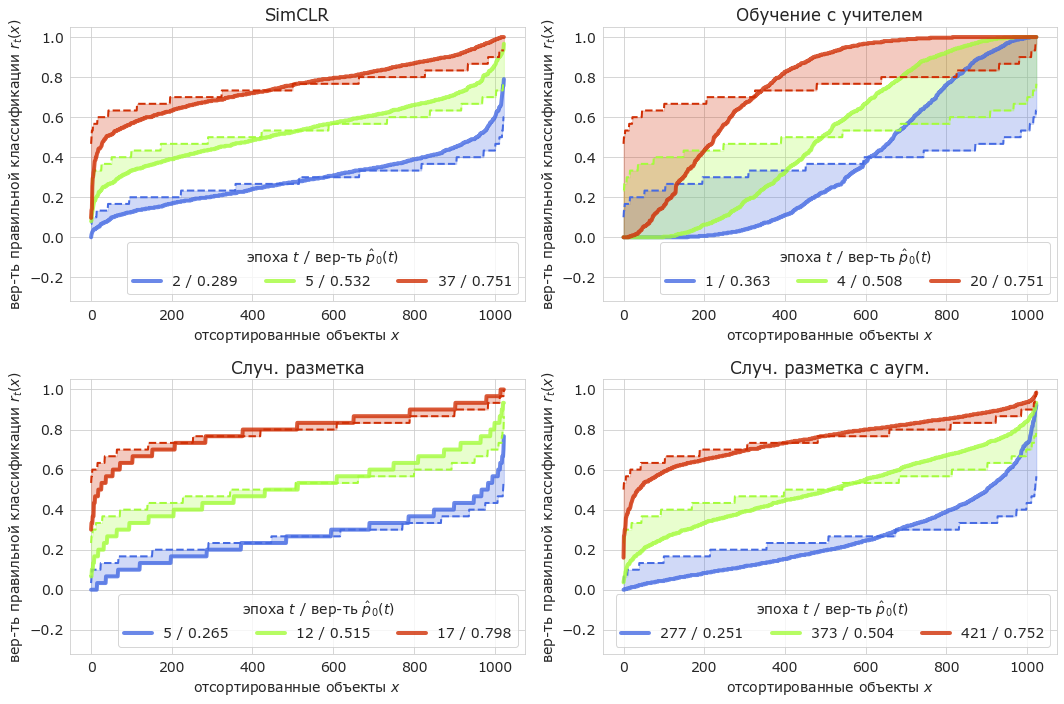

In [17]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
ratios = [0.25, 0.5, 0.75]
colors = sns.color_palette('turbo', 7)
colors = [colors[0], colors[3], colors[6]]

for i, ratio in enumerate(ratios):
    index = np.nonzero(simclr_areas >= ratio)[0][0]
    shares, _ = torch.sort(simclr_first['argmax'][:, index].mean((0, 1)))
    axs[0, 0].plot(shares, label=f'{index + 1} / {simclr_areas[index]:.3f}',
                   color=colors[i], linewidth=4, alpha=0.8)
    noise = binom.rvs(p=shares.mean(), n=30, size=1024) / 30
    axs[0, 0].plot(np.sort(noise), color=colors[i], linestyle='--', linewidth=2)
    axs[0, 0].fill_between(x=range(1024), y1=shares, y2=np.sort(noise),
                           color=colors[i], alpha=0.25)
    
for i, ratio in enumerate(ratios):
    index = np.nonzero(supervised_areas >= ratio)[0][0]
    shares, _ = torch.sort(supervised_stats['argmax'][:, index].mean((0, 1)))
    axs[0, 1].plot(shares, label=f'{index + 1} / {supervised_areas[index]:.3f}',
                   color=colors[i], linewidth=4, alpha=0.8)
    noise = binom.rvs(p=shares.mean(), n=30, size=1024) / 30
    axs[0, 1].plot(np.sort(noise), color=colors[i], linestyle='--', linewidth=2)
    axs[0, 1].fill_between(x=range(1024), y1=shares, y2=np.sort(noise),
                           color=colors[i], alpha=0.25)
    
for i, ratio in enumerate(ratios):
    index = np.nonzero(randy_areas >= ratio)[0][0]
    shares, _ = torch.sort(randy_stats['argmax'][:, index].mean((0, 1)))
    axs[1, 0].plot(shares, label=f'{index + 1} / {randy_areas[index]:.3f}',
                   color=colors[i], linewidth=4, alpha=0.8)
    noise = binom.rvs(p=shares.mean(), n=30, size=1024) / 30
    axs[1, 0].plot(np.sort(noise), color=colors[i], linestyle='--', linewidth=2)
    axs[1, 0].fill_between(x=range(1024), y1=shares, y2=np.sort(noise),
                           color=colors[i], alpha=0.25)

for i, ratio in enumerate(ratios):
    index = np.nonzero(randy_aug_areas >= ratio)[0][0]
    shares, _ = torch.sort(randy_aug_stats['argmax'][:, index].mean((0, 1)))
    axs[1, 1].plot(shares, label=f'{index + 1} / {randy_aug_areas[index]:.3f}',
                   color=colors[i], linewidth=4, alpha=0.8)
    noise = binom.rvs(p=shares.mean(), n=30, size=1024) / 30
    axs[1, 1].plot(np.sort(noise), color=colors[i], linestyle='--', linewidth=2)
    axs[1, 1].fill_between(x=range(1024), y1=shares, y2=np.sort(noise),
                           color=colors[i], alpha=0.25)

for ax in axs.flatten():
    ax.legend(ncol=3, title='эпоха $t$ / вер-ть $\hat{p}_0(t)$', loc='lower right')
    ax.set_ylabel(r'вер-ть правильной классификации $r_t(x)$')
    ax.set_xlabel('отсортированные объекты $x$')
    ax.set_ylim(ymin=-0.32)

axs[0, 0].set_title('SimCLR')
axs[0, 1].set_title('Обучение с учителем')
axs[1, 0].set_title('Случ. разметка')
axs[1, 1].set_title('Случ. разметка с аугм.')
plt.tight_layout()
plt.savefig('plots/binom_noise2.pdf')
plt.show()

In [18]:
def binom_area_diff(data, n):
    p = data.mean()
    noise = binom.rvs(n=n, p=p, size=data.shape[0]) / n
    score = np.abs(np.sort(data) - np.sort(noise)).mean()
    return score

def get_sample(tensor, epoch):
    return tensor[:, epoch].mean((0, 1)).numpy()

In [19]:
ratios = [0.25, 0.5, 0.75]

for ratio in ratios:
    index = np.nonzero(simclr_areas >= ratio)[0][0]
    sample = get_sample(simclr_first['argmax'], index)
    s = np.array([binom_area_diff(sample, n=30) for _ in range(10)])
    print(f'SimCLR: t={index + 1}, p={simclr_areas[index]:.3f}, mean={s.mean():.3f}, std={s.std():.3f}')

print()
for ratio in ratios:
    index = np.nonzero(supervised_areas >= ratio)[0][0]
    sample = get_sample(supervised_stats['argmax'], index)
    s = np.array([binom_area_diff(sample, n=30) for _ in range(10)])
    print(f'Обуч. с учителем: t={index + 1}, p={supervised_areas[index]:.3f}, mean={s.mean():.3f}, std={s.std():.3f}')

print()
for ratio in ratios:
    index = np.nonzero(randy_areas >= ratio)[0][0]
    sample = get_sample(randy_stats['argmax'], index)
    s = np.array([binom_area_diff(sample, n=30) for _ in range(10)])
    print(f'Случ. разметка: t={index + 1}, p={randy_areas[index]:.3f}, mean={s.mean():.3f}, std={s.std():.3f}')

print()
for ratio in ratios:
    index = np.nonzero(randy_aug_areas >= ratio)[0][0]
    sample = get_sample(randy_aug_stats['argmax'], index)
    s = np.array([binom_area_diff(sample, n=30) for _ in range(10)])
    print(f'Случ. разметка с аугм.: t={index + 1}, p={randy_aug_areas[index]:.3f}, mean={s.mean():.3f}, std={s.std():.3f}')

SimCLR: t=2, p=0.289, mean=0.042, std=0.001
SimCLR: t=5, p=0.532, mean=0.055, std=0.002
SimCLR: t=37, p=0.751, mean=0.049, std=0.001

Обуч. с учителем: t=1, p=0.363, mean=0.248, std=0.002
Обуч. с учителем: t=4, p=0.508, mean=0.269, std=0.002
Обуч. с учителем: t=20, p=0.751, mean=0.208, std=0.001

Случ. разметка: t=5, p=0.265, mean=0.037, std=0.002
Случ. разметка: t=12, p=0.515, mean=0.051, std=0.001
Случ. разметка: t=17, p=0.798, mean=0.031, std=0.002

Случ. разметка с аугм.: t=277, p=0.251, mean=0.094, std=0.002
Случ. разметка с аугм.: t=373, p=0.504, mean=0.082, std=0.001
Случ. разметка с аугм.: t=421, p=0.752, mean=0.038, std=0.002


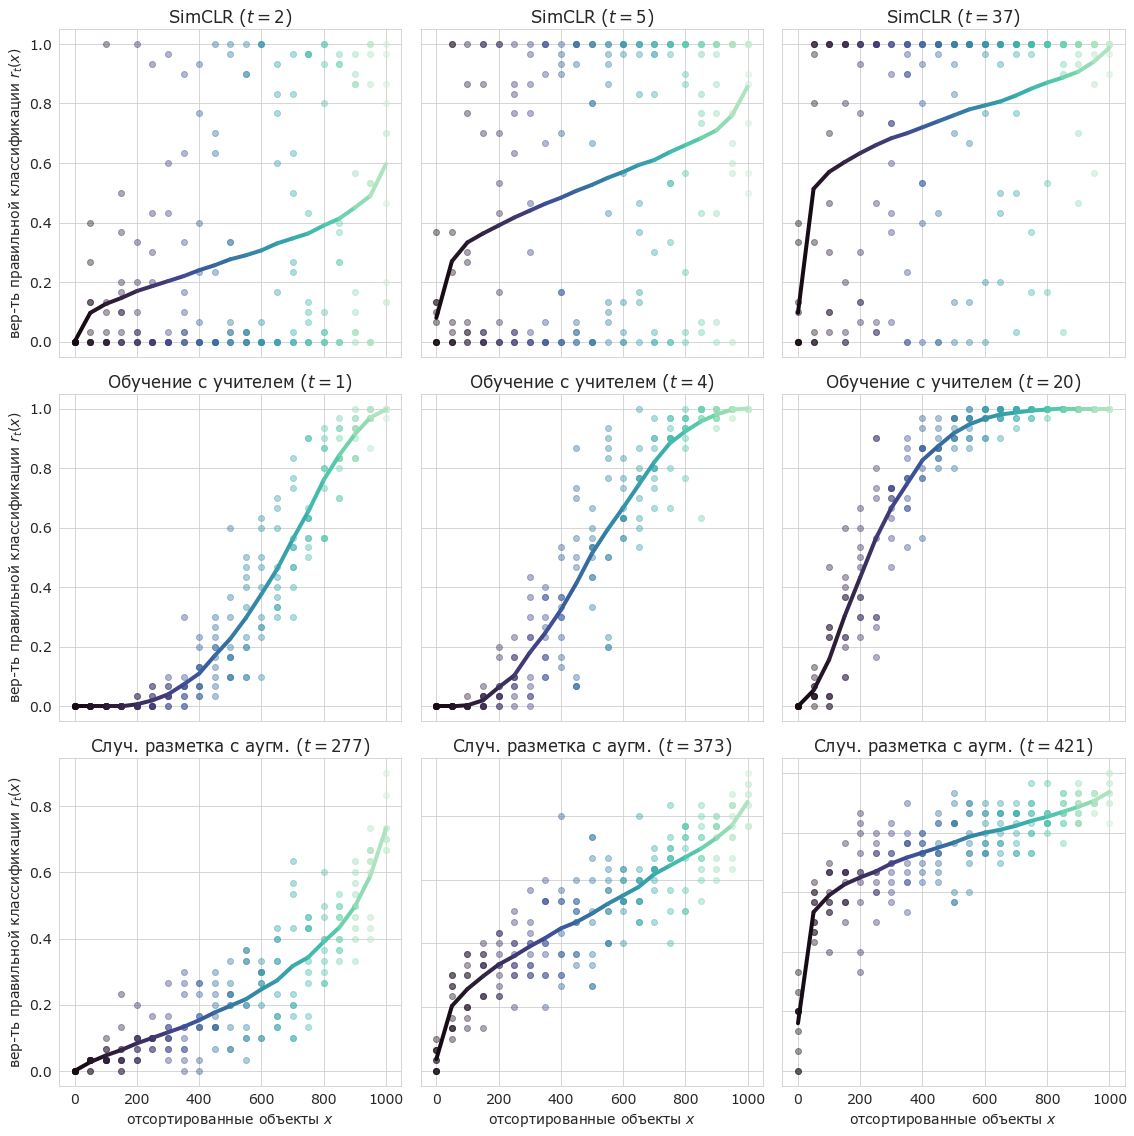

In [22]:
fig, axs = plt.subplots(3, 3, figsize=(16, 16))
all_epochs = [[2, 5, 37], [1, 4, 20], [277, 373, 421]]
tensors = [simclr_first['argmax'], supervised_stats['argmax'], randy_aug_stats['argmax']]
step = 50

for k, (tensor, epochs) in enumerate(zip(tensors, all_epochs)):
    for i, epoch in enumerate(epochs):
        shares = tensor[:, epoch - 1].mean((0)).numpy().T
        indices = np.argsort(shares.mean(1))
        indices = indices[::step]

        colors = sns.color_palette('mako', len(indices))
        for j in range(len(indices)):
            axs[k, i].scatter(x=np.full(10, step * j), y=shares[indices[j]], alpha=0.4, color=colors[j])

        for j in range(len(indices) - 1):
            axs[k, i].plot([step * j, step * (j + 1)], shares[indices[j:j+2]].mean(1), linewidth=4, color=colors[j])

methods = ['SimCLR', 'Обучение с учителем', 'Случ. разметка с аугм.']
for k, (method, epochs) in enumerate(zip(methods, all_epochs)):
    for i, epoch in enumerate(epochs):
        axs[k, i].set_title(f'{method} ($t = {epoch}$)')

for ax in axs[:-1].flatten():
    ax.set_xticklabels([])

for ax in axs[:, 1:].flatten():
    ax.set_yticklabels([])

for ax in axs[-1]:
    ax.set_xlabel('отсортированные объекты $x$')

for ax in axs[:, 0]:
    ax.set_ylabel(r'вер-ть правильной классификации $r_t(x)$')

plt.subplots_adjust(wspace=0.01, hspace=0.01)
plt.tight_layout()
plt.savefig('plots/augments.pdf')
plt.show()

In [23]:
from torchvision import datasets, transforms

train_dataset = datasets.CIFAR10('datasets/cifar10', train=True, transform=transforms.ToTensor(), download=True)

Files already downloaded and verified


In [24]:
labels = []
for index in supervised_stats['indices']:
    labels += [train_dataset[index][1]]
labels = torch.tensor(labels, dtype=torch.long)

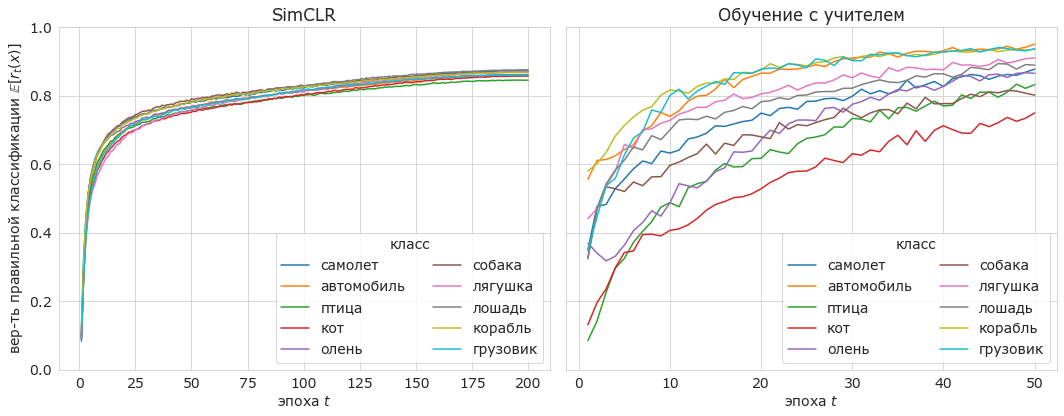

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
colors = sns.color_palette('tab10', 10)
classes = ['самолет', 'автомобиль', 'птица', 'кот', 'олень',
           'собака', 'лягушка', 'лошадь', 'корабль', 'грузовик']

for i in range(10):
    axs[0].plot(np.arange(1, 201), simclr_first['argmax'][:, :, :, labels == i].mean((0, 2, 3)),
                color=colors[i], label=classes[i])
    axs[1].plot(np.arange(1, 51), supervised_stats['argmax'][:, :, :, labels == i].mean((0, 2, 3)),
                color=colors[i], label=classes[i])

for ax in axs:
    ax.set_xlabel('эпоха $t$')
    ax.set_ylim([0, 1])
    ax.legend(ncol=2, loc='lower right', title='класс')

axs[0].set_ylabel(r'вер-ть правильной классификации $\mathbb{E} [r_t(x)]$')
axs[0].set_title('SimCLR')
axs[1].set_title('Обучение с учителем')
plt.subplots_adjust(wspace=0, hspace=0)
plt.tight_layout()
plt.savefig('plots/class_difficulties.pdf')
plt.show()